In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob
import random

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-10faf022-0998-7d80-d9ea-9ebe55c8ba85)


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# imports for building the network
import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, Dropout, concatenate
from tensorflow.keras.losses import binary_crossentropy


In [ ]:
from google.colab import  drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('/content/drive/My Drive/Tests/',
        target_size=(256,256), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 1108 images belonging to 1 classes.


In [ ]:
# ENCODER
input_img = Input(shape=(256, 256, 3))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)  #128, 128 ,_
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img) #64, 64 ,_
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)    #32, 32 ,_
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)    #16, 16_
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Conv2D(64, (1, 1), activation='relu', padding='same')(x)     #8,8 _

# LATENT SPACE
latentSize = (32,32,64)

# DECODER
direct_input = Input(shape=latentSize)

x = Conv2D(512, (1, 1), activation='relu', padding='same')(direct_input)   #8,8,1 , _
x = UpSampling2D((2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(direct_input)  #16,16, 3, _
x = UpSampling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(direct_input)  #32,32,3_
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  #64,64, 3, _
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)   #128,128,3,_
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)   #256,256,3,_
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)   #

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))


In [ ]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

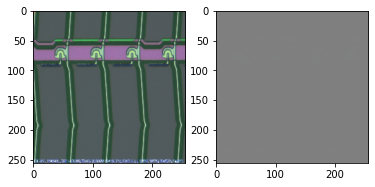

In [ ]:
for image in train_dataset.take(1):
  pred= autoencoder.predict(image)
 
  plt.subplot(1,2,1)
  plt.imshow(image[0,:,:,:])

  plt.subplot(1,2,2)
  plt.imshow(pred[0,:,:,:] )


In [ ]:
EPOCHS=100

In [ ]:
history = autoencoder.fit_generator(train_batches,steps_per_epoch = train_batches.samples // BATCH_SIZE ,epochs = EPOCHS, verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
34/34 - 484s - loss: 0.6512
Epoch 2/100
34/34 - 20s - loss: 0.6269
Epoch 3/100
34/34 - 19s - loss: 0.6204
Epoch 4/100
34/34 - 19s - loss: 0.6165
Epoch 5/100
34/34 - 19s - loss: 0.6129
Epoch 6/100
34/34 - 20s - loss: 0.6103
Epoch 7/100
34/34 - 20s - loss: 0.6097
Epoch 8/100
34/34 - 20s - loss: 0.6066
Epoch 9/100
34/34 - 20s - loss: 0.6054
Epoch 10/100
34/34 - 20s - loss: 0.6045
Epoch 11/100
34/34 - 19s - loss: 0.6041
Epoch 12/100
34/34 - 19s - loss: 0.6033
Epoch 13/100
34/34 - 20s - loss: 0.6028
Epoch 14/100
34/34 - 20s - loss: 0.6026
Epoch 15/100
34/34 - 20s - loss: 0.6019
Epoch 16/100
34/34 - 19s - loss: 0.6016
Epoch 17/100
34/34 - 20s - loss: 0.6017
Epoch 18/100
34/34 - 20s - loss: 0.6012
Epoch 19/100
34/34 - 20s - loss: 0.6010
Epoch 20/100
34/34 - 20s - loss: 0.6007
Epoch 21/100
34/34 - 20s - loss: 0.6007
Epoch 22/100
34/34 - 20s - loss: 0.6003
Epoch 23/100
34/34 - 19s - loss: 0.6004
Epoch 24/100

In [ ]:
autoencoder.save_weights('/content/drive/My Drive/Tests/')

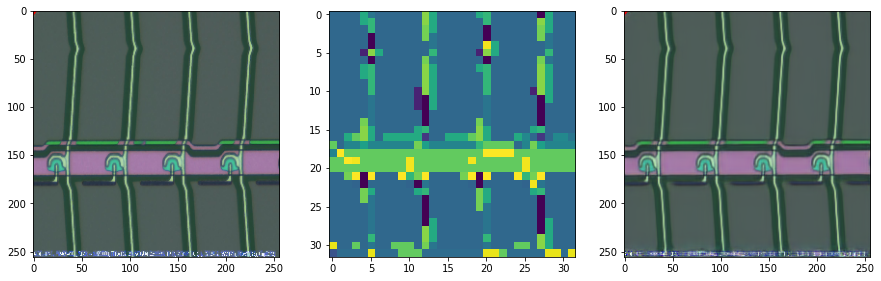

In [ ]:
images = next(iter(train_batches))
img=images[0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
    
# ORIGINAL IMAGE
plt.imshow(img[0,:,:,:])

# LATENT IMAGE
plt.subplot(1,3,2)
latent=encoder.predict(img[:,:,:,:])
pred= tf.argmax(latent[0,:,:,:], axis=-1)
plt.imshow(pred)


# RECONSTRUCTED IMAGE
plt.subplot(1,3,3)
decoded_imgs = decoder.predict(latent)
plt.imshow(decoded_imgs[0])

In [ ]:
#'/content/drive/My Drive/Tests/'
#'/content/drive/My Drive/Dataset/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_batches = train_datagen.flow_from_directory('/content/drive/My Drive/Dataset/B/',target_size=(256,256), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 620 images belonging to 1 classes.


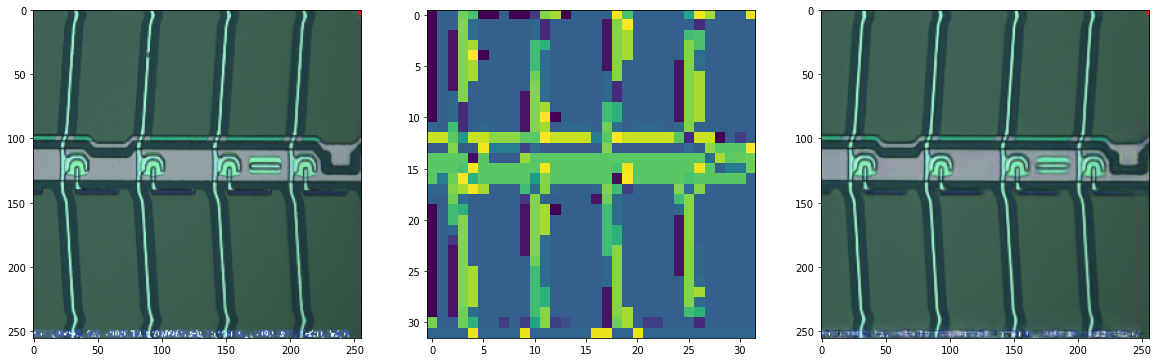

In [ ]:
images_test = next(iter(test_batches))
img_test=images_test[0]
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
    
# ORIGINAL IMAGE
plt.imshow(img_test[0,:,:,:])

# LATENT IMAGE
plt.subplot(1,3,2)
latent_test=encoder.predict(img_test[:,:,:,:])
pred_test= tf.argmax(latent_test[0,:,:,:], axis=-1)
plt.imshow(pred_test)


# RECONSTRUCTED IMAGE
plt.subplot(1,3,3)
decoded_imgs_test = decoder.predict(latent_test)
plt.imshow(decoded_imgs_test[0])

